# RLDT


## Step 1: Import the necessary libraries:


In [192]:
import numpy as np
import pandas as pd
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import itertools
import ast
import matplotlib.pyplot as plt 

In [193]:
num_IOT_devices = 10

voltages_frequencies_IOT = [
    (10e6  , 1.8),
    (20e6  , 2.3),
    (40e6  , 2.7),
    (80e6  , 4.0),
    (160e6 , 5.0),
]

num_MEC_devices = 5

voltages_frequencies_MEC = [
    (1500e6 ,  1.2),
    (1000e6 ,  1.0),
    (750e6, 0.825),
    (600e6, 0.8),
]

task_kinds = [1,2,3,4]

min_num_nodes_dag = 4
max_num_nodes_dag = 20
max_num_parents_dag = 5
num_dag_generations = 10000

dataFile = "./../results/OnlyEnergyResults.csv"


## Step 2: Define the environment:


#### ALL THE DEVICES


In [194]:


devices = pd.read_csv("./../resources/devices.csv")
devices["voltages_frequencies"] = devices["voltages_frequencies"].apply(lambda x: ast.literal_eval(x))
devices["capacitance"] = devices["capacitance"].apply(
    lambda x: ast.literal_eval(x)
)
devices["occupied_cores"] = devices["occupied_cores"].apply(
    lambda x: ast.literal_eval(x)
)
devices["powerIdle"] = devices["powerIdle"].apply(
    lambda x: ast.literal_eval(x)
)
devices["acceptableTasks"] = devices["acceptableTasks"].apply(
    lambda x: ast.literal_eval(x)
)
devices = devices.drop(["Unnamed: 0"],axis=1)
# devices

### Step 2.2: Application


#### _ALL THE TASKS_


In [195]:
def read_tasks():
    tasks = pd.read_csv('./../resources/tasks.csv')
    tasks = tasks.sample(frac=1)
    tasks = tasks.set_index("id")
    tasks_copy = tasks.copy()
    tasks_copy = tasks_copy.drop(["job","dependency","mobility","status"],axis=1)
    taskList = tasks_copy.index.tolist()
    return taskList, tasks_copy

## Step 4 : DDT


### Step 4.1: Initializing The tree


In [196]:
class DDT(nn.Module):
    def __init__(self, num_input, num_output, depth, max_depth):
        super(DDT, self).__init__()
        self.depth = depth
        self.max_depth = max_depth
        if depth != max_depth:
            # self.weights = nn.Parameter(torch.zeros(num_input))
            self.weights = nn.Parameter(torch.empty(
                num_input).normal_(mean=0, std=0.1))
            self.bias = nn.Parameter(torch.zeros(1))
        if depth == max_depth:
            self.prob_dist = nn.Parameter(torch.zeros(num_output))

        if depth < max_depth:
            self.left = DDT(num_input, num_output, depth + 1, max_depth)
            self.right = DDT(num_input, num_output, depth + 1, max_depth)

    def forward(self, x):
        if self.depth == self.max_depth:
            return self.prob_dist
        val = torch.sigmoid(torch.matmul(x, self.weights.t()) + self.bias)
        a = np.random.uniform(0, 1)
        if a < 0.1:
            val = 1 - val
        if val >= 0.5:

            return val * self.right(x)
        else:

            return (1 - val) * self.left(x)

## Step 5: RL


In [197]:
def calc_execution_time(device, task, core, dvfs):
    if device['id'] == "cloud":
        return task["computationalLoad"] / device["voltages_frequencies"][0]
    else:
        return task["computationalLoad"] / device["voltages_frequencies"][core][dvfs][0]


def calc_power_consumption(device, task, core, dvfs):
    if device['id'] == "cloud":
        return 13.85 
    return (
        device["capacitance"][core]
        * (device["voltages_frequencies"][core][dvfs][1] ** 2)
        * device["voltages_frequencies"][core][dvfs][0]
    )
def calc_energy(device, task, core, dvfs):
    return calc_execution_time(device, task, core, dvfs) * calc_power_consumption(device, task, core, dvfs)


def calc_total(device, task, core, dvfs):
    timeTransMec = 0
    timeTransCC = 0
    exeTime = 0
    e = 0

    transferRate5g =1e9
    latency5g=5e-3
    transferRateFiber =1e10
    latencyFiber=1e-3

    timeDownMec = task["returnDataSize"] / transferRate5g
    timeDownMec += latency5g
    timeUpMec = task["dataEntrySize"] / transferRate5g
    timeUpMec += latency5g

    alpha = 52e-5
    beta = 3.86412
    powerMec = alpha * 1e9 / 1e6 + beta

    timeDownCC = task["returnDataSize"] / transferRateFiber
    timeDownCC += latencyFiber
    timeUpCC = task["dataEntrySize"] / transferRateFiber
    timeUpCC += latencyFiber

    powerCC = 3.65 


    if device["id"].startswith("mec"):
        timeTransMec =  timeUpMec +  timeDownMec 
        energyTransMec = powerMec *  timeTransMec
        exeTime = calc_execution_time(device, task, core, dvfs)
        totalTime = exeTime + timeTransMec 
        e = calc_energy(device, task, core, dvfs)
        totalEnergy =  e + energyTransMec

    elif device['id'].startswith("cloud"):
        timeTransMec =  timeUpMec +  timeDownMec 
        energyTransMec = powerMec * timeTransMec
        
        timeTransCC = timeUpCC+timeDownCC
        energyTransCC =  powerCC * timeTransCC
        
        exeTime = calc_execution_time(device, task, core, dvfs)
        totalTime =  exeTime + timeTransMec +timeTransCC

        e = calc_energy(device, task, core, dvfs)
        totalEnergy = e + energyTransMec + energyTransCC

    elif device['id'].startswith("iot"):
        exeTime = calc_execution_time(device, task, core, dvfs)
        totalTime = exeTime
        e = calc_energy(device, task, core, dvfs)
        totalEnergy = e

    return totalTime , totalEnergy

In [198]:
def getPunish(rSetup):
    match rSetup:
        case "00":
            p = 10
        case "01":
            p = 10
        case "02":
            p = 100
        case "03":
            p = 100
        case "04":
            p = 20
        case "05":
            p = 20
        case "06":
            p = 15
        case "07":
            p = 15
        case "08":
            p = 10
        case "09":
            p = 10
    
    return p

In [199]:
def plot_histories(rSetup, punish, learning_mode, lossHistory, avg_time_history, avg_energy_history, avg_fail_history):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Create a grid of 2x2 for plots

    # Set a comprehensive title for the figure with dynamic parameters
    plt.suptitle(f"Training History with setup {rSetup}, punish: {punish}, mode: {learning_mode}", fontsize=16, fontweight='bold')

    # Plot for average loss history
    loss_values = [l.detach().numpy() if isinstance(l, torch.Tensor) else l for l in lossHistory]
    axs[0, 0].plot(loss_values, label='Average Loss', color='blue', marker='o')  # Add markers for clarity
    axs[0, 0].set_title('Average Loss History')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot for average time history
    time_values = np.array(avg_time_history)  # Ensure data is in numpy array
    axs[0, 1].plot(time_values, label='Average Time', color='red', marker='o')
    axs[0, 1].set_title('Average Time History')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Time')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot for average energy history
    energy_values = np.array(avg_energy_history)
    axs[1, 0].plot(energy_values, label='Average Energy', color='green', marker='o')
    axs[1, 0].set_title('Average Energy History')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Energy')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot for average fail history
    fail_values = np.array(avg_fail_history)
    axs[1, 1].plot(fail_values, label='Average Fail', color='purple', marker='o')
    axs[1, 1].set_title('Average Fail History')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Fail Count')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent overlap, leaving space for the title
    plt.savefig(f"./../results/Only Energy Figs/r{rSetup}_p{punish}_m{learning_mode}")

In [200]:
def checkIfSuitable(state, device, punish):
    punishment = 0
    safeFail = 0
    taskFail = 0
    if  state['safe'] and not device["handleSafeTask"]:
        punishment += 1
        safeFail += 1
        
    if state['kind'] not in device["acceptableTasks"]:
        punishment += 1
        taskFail += 1
    # return taskFail, safeFail
    return (punishment if punishment > 0 else 0, taskFail, safeFail)

In [201]:
def getSetup(e, setup, alpha=1, beta=1):
    t = 0
    match setup:
        case "00":
            reward = -1 * (alpha * e + beta * t)
        case "01":
            reward = -1 / (alpha * e + beta * t)
        case "02":
            reward = -np.exp(alpha * e) - np.exp(beta * t)
        case "03":
            reward = -np.exp(alpha * e + beta * t)
        case "04":
            reward = np.exp(-1 * (alpha * e + beta * t))
        case "05":
            reward = np.log(alpha * e + beta * t)
        case "06": 
            reward = -((alpha * e + beta * t) ** 2)
    
    return reward

In [202]:
class Environment:
    def __init__(self):
        self.learning_mode = 0
        self.rSetup = "01"
        self.punish = 0
        self.alpha = 1
        self.beta = 1
        self.last_epoch_t = 0
        self.last_epoch_l = 0
        self.last_epoch_e = 0
        self.taskList = []
        self.tasks_copy = None
        self.totalSafeFail = 0
        self.totalTaskFail = 0
        self.totalReward = 0
        self.feature_size = 5
        self.num_actions = len(devices)
        self.max_depth = 3
        self.agent = DDT(self.feature_size, self.num_actions,
                         depth=0, max_depth=self.max_depth)
        self.optimizer = optim.Adam(self.agent.parameters(), lr=0.005)
        self.avg_time_history = []
        self.avg_energy_history = []
        self.avg_fail_history = []
        self.avg_safe_fail_history = []
        self.avg_task_fail_history = []
     
    def execute_action(self, state, action):
        self.taskList.pop(0)
        device = devices.iloc[action]        

        punishment, taskFail, safeFail = checkIfSuitable(state, device, self.punish)

        # taskFail, safeFail = checkIfSuitable(state, device)
        punishment *= self.punish
        

        if safeFail:
            self.totalSafeFail += 1
            self.totalFail += 1
        if taskFail:
            self.totalTaskFail += 1
            self.totalFail += 1


        if not (punishment):
            for coreIndex in range(len(device["occupied_cores"])):
                if device["occupied_cores"][coreIndex] == 0:
                    total_t, total_e  = calc_total(device, state, coreIndex,np.random.randint(0,3))
                    reward = getSetup(total_e, self.rSetup, alpha=self.alpha, beta=self.beta)
                    # reward = -1 / (total_t + total_e)
                    # print(f"device {device['id']} ////// time {total_t}  ////// energy {total_e} ")
                    self.totalReward += reward
                    return (self.tasks_copy.loc[self.taskList[0]], reward, total_t, total_e)
        # self.totalFail += 1
        return (self.tasks_copy.loc[self.taskList[0]], punishment, 0, 0)
    

    def train(self, num_epoch, num_episodes):

        total_avg_t = 0
        total_avg_e = 0
        total_avg_r = 0
        total_avg_l = 0
        
        self.safeFailHistory = []
        self.taskFailHistory = []
        self.lossHistory = []

        half_num_epoch = (num_epoch - 1) // 2
        
        for i in range(num_epoch):
            


            total_loss = 0
            self.totalFail = 0
            self.totalTaskFail = 0
            self.totalSafeFail = 0
            self.totalReward = 0
            total_loss = 0
            total_reward = 0
            totalTime = 0
            totalEnergy = 0


            
            for j in range(num_episodes):
                state = self.tasks_copy.loc[self.taskList[0]]
                x = torch.tensor(np.array(state.values, dtype=np.float32)).unsqueeze(0)
                
                output = self.agent(x)
                action_probabilities = torch.softmax(output, dim=0)
                action_index = torch.multinomial(action_probabilities, 1).item()
                # action_index = torch.argmax(action_probabilities).item()

                next_state, reward, t, e = self.execute_action(state, action_index)
                loss = (output[action_index] * reward)

                if self.learning_mode == 0:
                    #single reward:
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    
                total_reward += reward
                total_loss += loss
                
                totalTime += t
                totalEnergy += e
                
            if self.learning_mode == 1:
                    #total
                    self.optimizer.zero_grad()
                    total_loss.backward()
                    self.optimizer.step()   
            
            avg_time = totalTime / num_episodes
            avg_energy = totalEnergy / num_episodes
            # avg_reward = total_reward / num_episodes
            avg_reward = self.totalReward / num_episodes
            avg_loss = total_loss/num_episodes

            if self.learning_mode == 2:
                #avg
                self.optimizer.zero_grad()
                avg_loss = total_loss/num_episodes
                avg_loss.backward()
                self.optimizer.step()
                

            
            
            self.lossHistory.append(avg_loss)
            self.avg_time_history.append(avg_time)
            self.avg_energy_history.append(avg_energy)
            self.avg_fail_history.append(self.totalFail)
            self.avg_safe_fail_history.append(self.totalSafeFail)
            self.avg_task_fail_history.append(self.totalTaskFail)


            total_avg_t += avg_time
            total_avg_e += avg_energy
            total_avg_l += avg_loss
            total_avg_r += avg_reward
            

            
            if i % 1 == 0:
                # print(f"Epoch {i+1} // avg cc time: {avg_cc} // avg mec: {avg_mec} // avg og time: {avg_og} total fail: {env.totalFail} // Average Loss: {avg_loss}// ")
                # print(f"Epoch {i+1} // avg time: {avg_time} // avg added Time: {avg_added_time} // avg og time: {avg_og} total fail: {env.totalFail} // Average Loss: {avg_loss}// ")
                # print(f"Epoch {i+1}  // safe/task fail: {self.totalSafeFail}/{self.totalTaskFail} // Average Loss: {avg_loss:.2f} // Total Reward: {self.totalReward:.2f} // Average Reward: {avg_reward:.2f} // Avg time: {avg_time:.2f} // Avg energy: {avg_energy:.2f}")
                pass
            

            
            if i == num_epoch - 1:

                self.last_epoch_t = avg_time
                self.last_epoch_l = avg_loss
                self.last_epoch_e = avg_energy
                
            
                
            #     print(f"safe/task fail: {env.totalSafeFail}/{env.totalTaskFail} // Average Loss: {avg_loss:.2f} // Total Reward: {env.totalReward:.2f} // Average Reward: {avg_reward:.2f} // Avg time: {avg_time:.2f} // Avg energy: {avg_energy:.2f}")

                # env.totalFail = 0
            self.taskFailHistory.append(self.totalTaskFail)
            self.safeFailHistory.append(self.totalSafeFail)

            self.totalSafeFail = 0
            self.totalTaskFail = 0

        

        

        avg_avg_t = total_avg_t / num_epoch
        avg_avg_l = total_avg_l / num_epoch
        avg_avg_r = total_avg_r / num_epoch
        avg_avg_e = total_avg_e / num_epoch

        # Initializing variables to default values
        last_safe_index = 0  
        last_task_index = 0  

        safe_fail_indices = [i for i, x in enumerate(self.safeFailHistory) if x != 0]
        if safe_fail_indices:
            last_safe_index = safe_fail_indices[-1] + 1
        
        task_fail_indices = [i for i, x in enumerate(self.taskFailHistory) if x != 0]
        if task_fail_indices:
            last_task_index = task_fail_indices[-1] + 1
        
        task_fail_percent = len(task_fail_indices) / num_epoch
        safe_fail_percent = len(safe_fail_indices) / num_epoch
        is_loss_min = 1 if self.last_epoch_l < min(self.lossHistory) else 0

        first_10_avg_time = np.mean(self.avg_time_history[:10])
        first_10_avg_energy = np.mean(self.avg_energy_history[:10])
        first_10_avg_safe_fail = np.mean(self.avg_safe_fail_history[:10])
        first_10_avg_task_fail = np.mean(self.avg_task_fail_history[:10])
        first_10_total_fail = np.sum(self.taskFailHistory[:10]) + np.sum(self.safeFailHistory[:10])
        first_10_fail_arr = [first_10_total_fail, first_10_avg_task_fail, first_10_avg_safe_fail]

        mid_10_avg_time = np.mean(self.avg_time_history[half_num_epoch:half_num_epoch + 10])
        mid_10_avg_energy = np.mean(self.avg_energy_history[half_num_epoch:half_num_epoch + 10])
        mid_10_avg_safe_fail = np.mean(self.avg_safe_fail_history[half_num_epoch:half_num_epoch + 10])
        mid_10_avg_task_fail = np.mean(self.avg_task_fail_history[half_num_epoch:half_num_epoch + 10])
        mid_10_total_fail = np.sum(self.taskFailHistory[half_num_epoch:half_num_epoch + 10]) + np.sum(self.safeFailHistory[half_num_epoch:half_num_epoch + 10])
        mid_10_fail_arr = [mid_10_total_fail, mid_10_avg_task_fail, mid_10_avg_safe_fail]

        last_10_avg_time = np.mean(self.avg_time_history[-10:])
        last_10_avg_energy = np.mean(self.avg_energy_history[-10:])
        last_10_avg_safe_fail = np.mean(self.avg_safe_fail_history[-10:])
        last_10_avg_task_fail = np.mean(self.avg_task_fail_history[-10:])
        last_10_total_fail = np.sum(self.taskFailHistory[-10:]) + np.sum(self.safeFailHistory[-10:])
        last_10_fail_arr = [last_10_total_fail, last_10_avg_task_fail, last_10_avg_safe_fail]

        new_epoch_data = {
            "Setup": [self.rSetup],
            "Learning Mode": [self.learning_mode],
            "Punishment": [self.punish],
            "Alpha": [self.alpha],
            "Beta": [self.beta],
            "Average Loss": [avg_avg_l.detach().numpy() if isinstance(avg_avg_l, torch.Tensor) else avg_avg_l],
            "Last Epoch Loss": [self.last_epoch_l.detach().numpy() if isinstance(self.last_epoch_l, torch.Tensor) else self.last_epoch_l],
            "is Loss min": [is_loss_min.detach().numpy() if isinstance(is_loss_min, torch.Tensor) else is_loss_min],
            "Task Converge": [last_task_index.detach().numpy() if isinstance(last_task_index, torch.Tensor) else last_task_index],
            "Task Fail Percentage": [task_fail_percent.detach().numpy() if isinstance(task_fail_percent, torch.Tensor) else task_fail_percent],
            "Safe Converge": [last_safe_index.detach().numpy() if isinstance(last_safe_index, torch.Tensor) else last_safe_index],
            "Safe Fail Percentage": [safe_fail_percent.detach().numpy() if isinstance(safe_fail_percent, torch.Tensor) else safe_fail_percent],
            "Average Time": [avg_avg_t.detach().numpy() if isinstance(avg_avg_t, torch.Tensor) else avg_avg_t],
            "Last Epoch Time": [self.last_epoch_t.detach().numpy() if isinstance(self.last_epoch_t, torch.Tensor) else self.last_epoch_t],
            "Average Energy": [avg_avg_e.detach().numpy() if isinstance(avg_avg_e, torch.Tensor) else avg_avg_e],
            "Last Epoch Energy": [self.last_epoch_e.detach().numpy() if isinstance(self.last_epoch_e, torch.Tensor) else self.last_epoch_e],
            "Average Reward": [avg_avg_r.detach().numpy() if isinstance(avg_avg_r, torch.Tensor) else avg_avg_r],
            "Total Reward": [total_reward.detach().numpy() if isinstance(total_reward, torch.Tensor) else total_reward],

            "First 10 Avg Time": [first_10_avg_time.detach().numpy() if isinstance(first_10_avg_time, torch.Tensor) else first_10_avg_time],
            "Mid 10 Avg Time": [mid_10_avg_time.detach().numpy() if isinstance(mid_10_avg_time, torch.Tensor) else mid_10_avg_time],
            "Last 10 Avg Time": [last_10_avg_time.detach().numpy() if isinstance(last_10_avg_time, torch.Tensor) else last_10_avg_time],
            "First 10 Avg Energy": [first_10_avg_energy.detach().numpy() if isinstance(first_10_avg_energy, torch.Tensor) else first_10_avg_energy],
            "Mid 10 Avg Energy": [mid_10_avg_energy.detach().numpy() if isinstance(mid_10_avg_energy, torch.Tensor) else mid_10_avg_energy],
            "Last 10 Avg Energy": [last_10_avg_energy.detach().numpy() if isinstance(last_10_avg_energy, torch.Tensor) else last_10_avg_energy],
            "First 10 (total, task, safe) Fail": [first_10_fail_arr],
            "Mid 10 (total, task, safe) Fail": [mid_10_fail_arr],
            "Last 10 (total, task, safe) Fail": [last_10_fail_arr]
        }   



        # print(f'Overall Average Time across all epochs: {avg_avg_t}')
        # print(f'Overall Average e across all epochs: {avg_avg_e:.2f}')
        # print(f'Overall Average l across all epochs: {avg_avg_l:.2f}')
        # print(f'Overall Average r across all epochs: {avg_avg_r:.2f}') 

        df = pd.read_csv(dataFile)

        # Convert the new data into a DataFrame and concatenate it
        new_df = pd.DataFrame(new_epoch_data)
        df = pd.concat([df, new_df], ignore_index=True)

        # Save the updated DataFrame back to CSV
        df.to_csv(dataFile, index=False)

        plot_histories(self.rSetup, self.punish, self.learning_mode, self.lossHistory, self.avg_time_history, self.avg_energy_history, self.avg_fail_history)



        # print(f'Overall Average Time across all epochs: {avg_avg_t}')
        # print(f'Overall Average e across all epochs: {avg_avg_e:.2f}')
        # print(f'Overall Average l across all epochs: {avg_avg_l:.2f}')
        # print(f'Overall Average r across all epochs: {avg_avg_r:.2f}')
     





# env.totalAddedAvg += avg_cc


# env = Environment()
# tree = env.agent
# env.train(1001, 10)

# print('///////////////////')

# for name, param in env.agent.named_parameters():
#     if "prob_dist" or "bias" not in name:
#         # print(name,param)
#         pass

In [203]:

# def train_test(n):
#     rpSetup_list = {"00": [10, 100, 1000], "01": [100, 1000, 10000], "02": [20, 200, 2000], "03": [15, 150, 1500], "04": [10, 100, 1000], "05": [20, 200, 2000], "06": [2, 20, 200] }
#     learningModes = [0, 1, 2]

#     for i in range(n):
#         for reward, punish_list in rpSetup_list.items():
#             for punish in punish_list:
#                     for mode in learningModes:
#                         taskList, tasks_copy = read_tasks()
#                         env = Environment()
#                         env.learning_mode = mode
#                         env.rSetup = reward
#                         env.punish = punish
#                         env.taskList = taskList
#                         env.tasks_copy = tasks_copy
                        
#                         tree = env.agent
#                         env.train(10001, 10)

# train_test(1)   
# print("completed")


In [204]:

# # Define the column headers as a list
# headers = [
#     "Setup","Learning Mode", "Punishment", "Alpha", "Beta","Average Loss", "Last Epoch Loss", "is Loss min", "Task Converge", "Task Fail Percentage", "Safe Converge", "Safe Fail Percentage", "Average Time","Last Epoch Time",
#     "Average Energy", "Last Epoch Energy", "Average Reward", "Total Reward", "First 10 Avg Time", "Mid 10 Avg Time","Last 10 Avg Time","First 10 Avg Energy", "Mid 10 Avg Energy","Last 10 Avg Energy", "First 10 (total, task, safe) Fail", "Mid 10 (total, task, safe) Fail", "Last 10 (total, task, safe) Fail"
# ]
# # Create an empty DataFrame with these headers
# df = pd.DataFrame(columns=headers)

# # Specify the filename
# filename = dataFile

# # Save the DataFrame to a CSV file
# df.to_csv(filename, index=False)

# print(f"CSV file '{filename}' created successfully with headers only.")

/var/folders/_r/7fw_p5qd057b2drkmtmpn2l80000gn/T/ipykernel_65470/463221930.py:262: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df], ignore_index=True)


completed


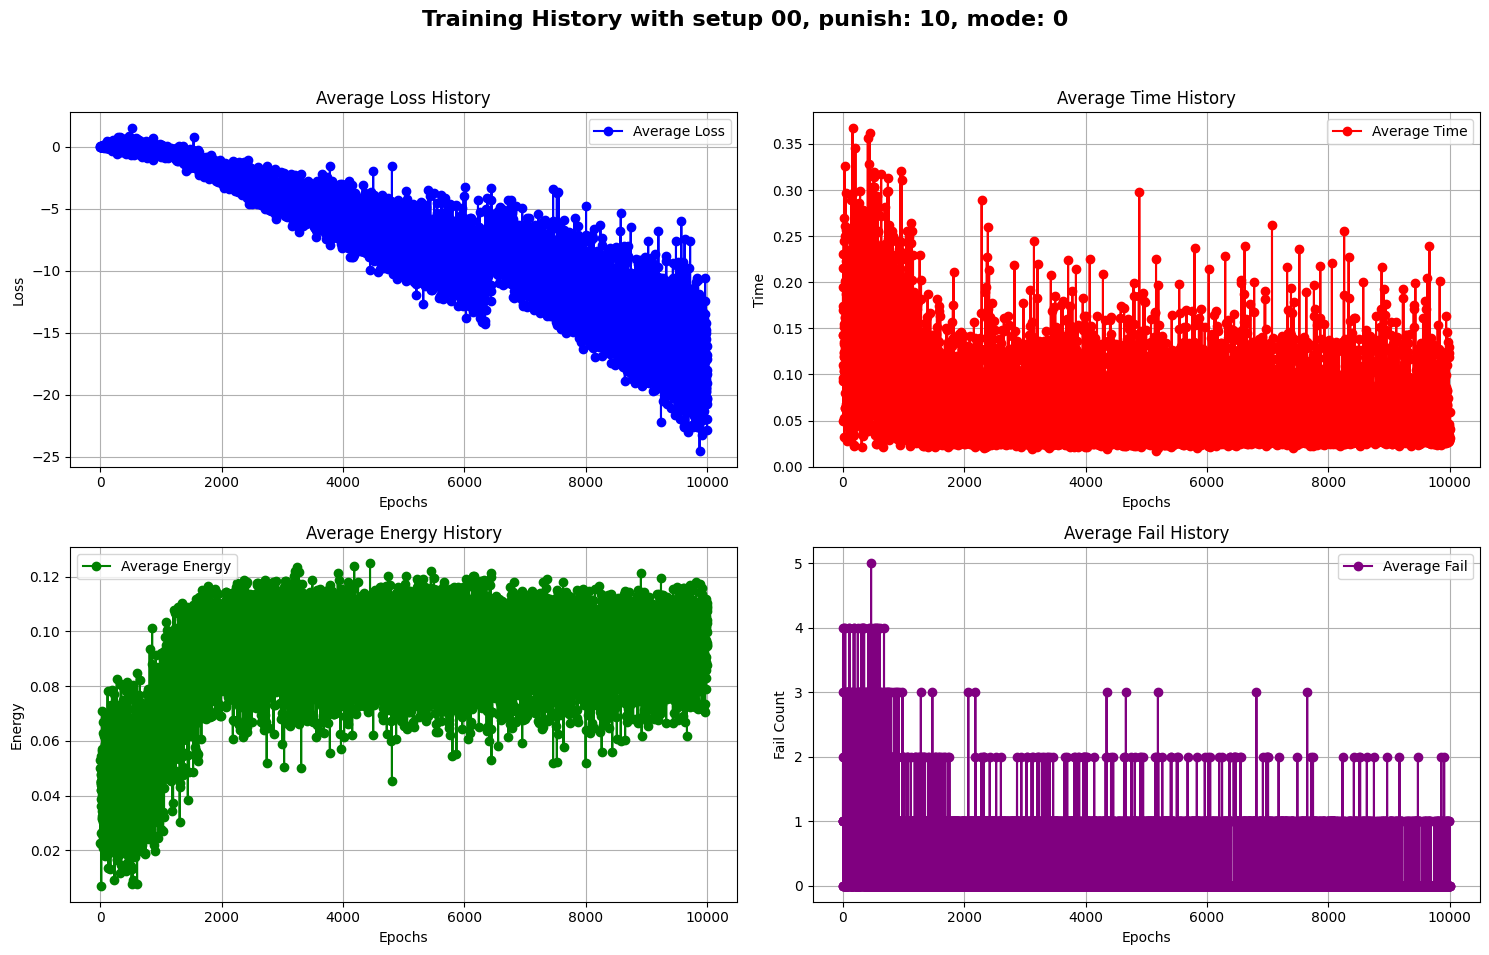

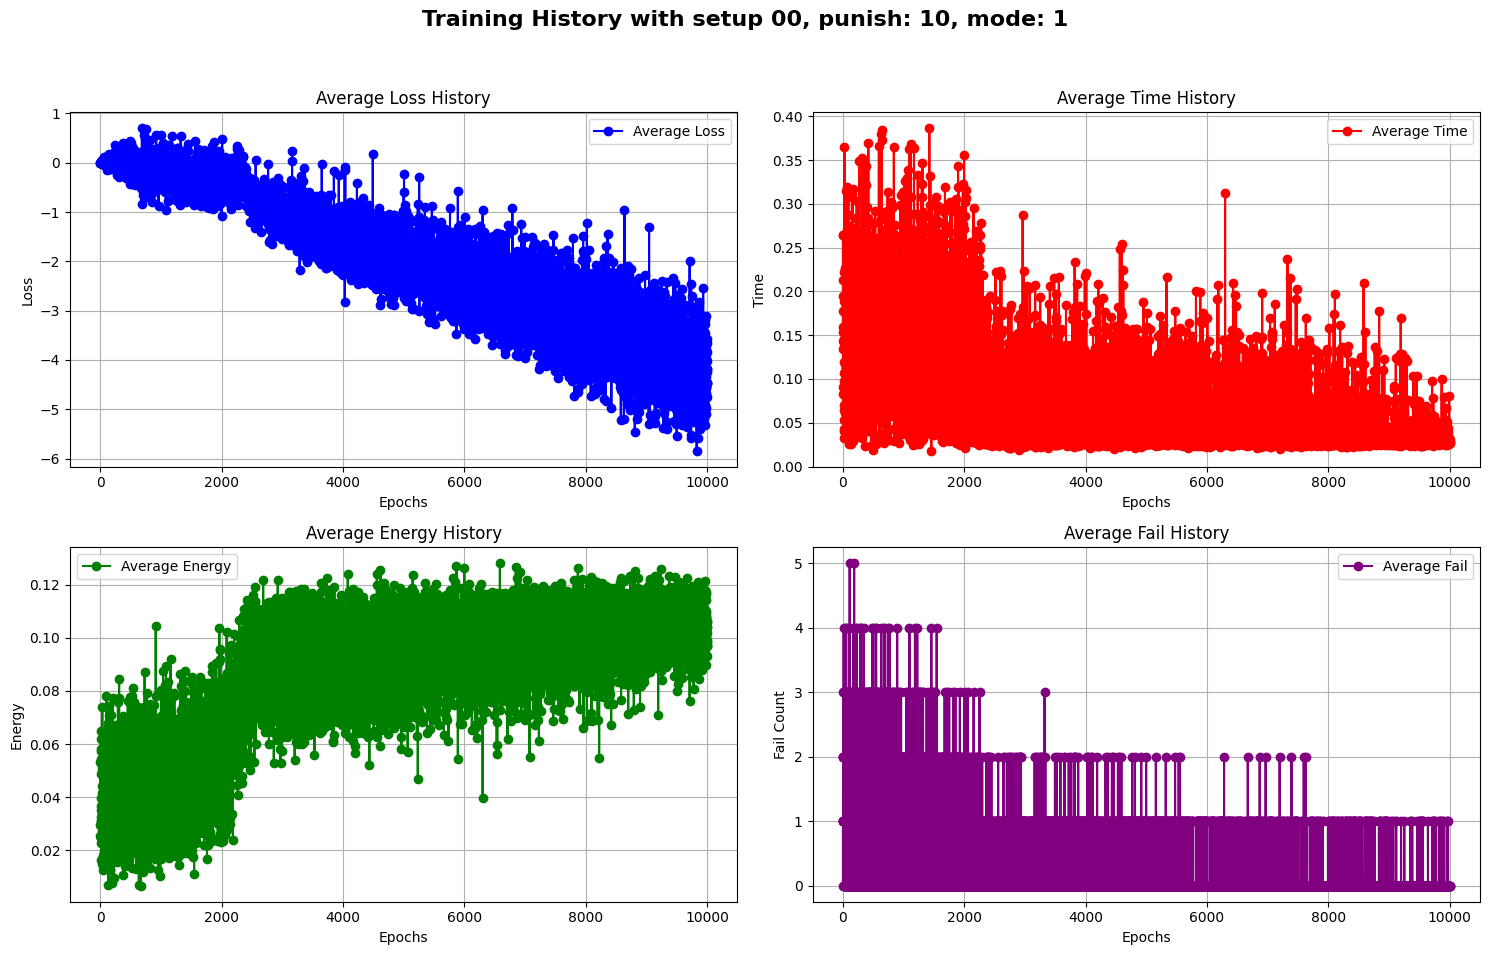

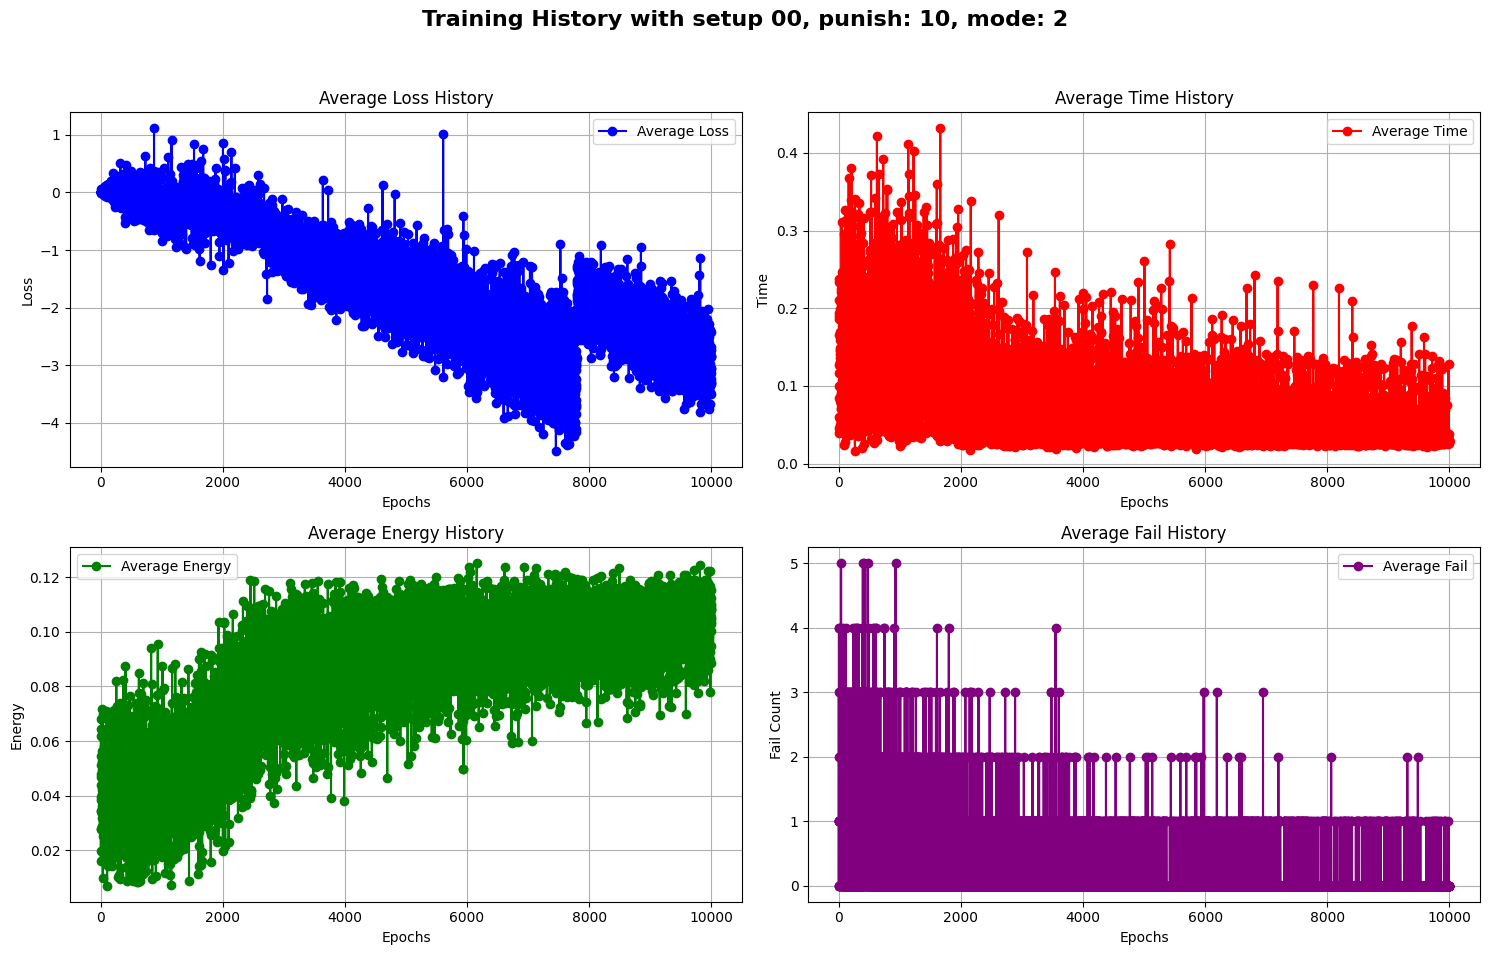

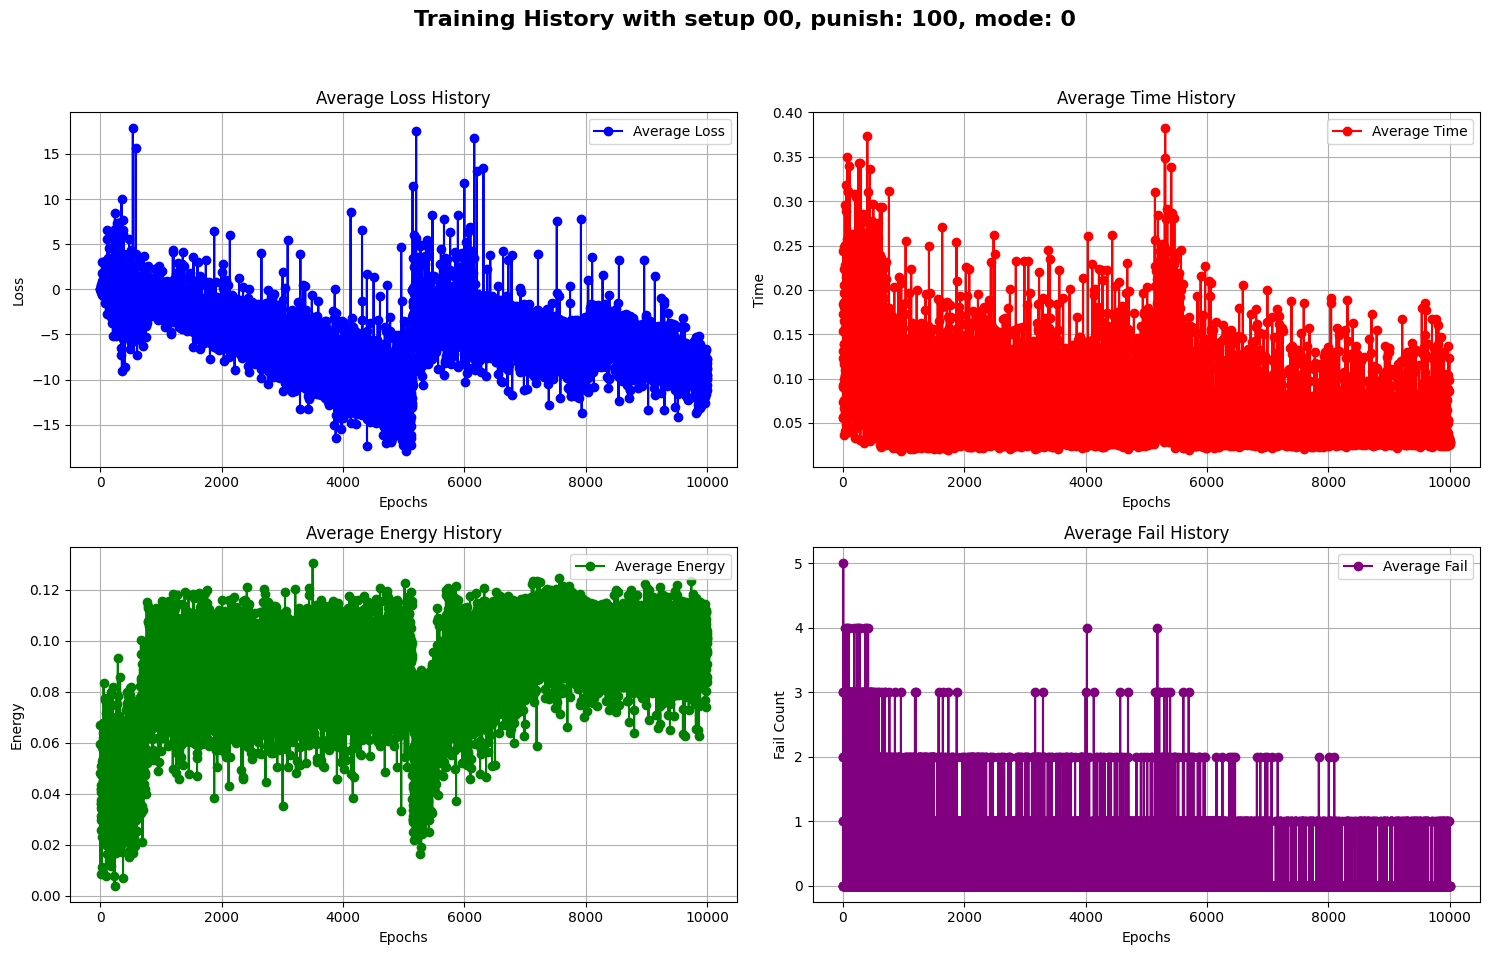

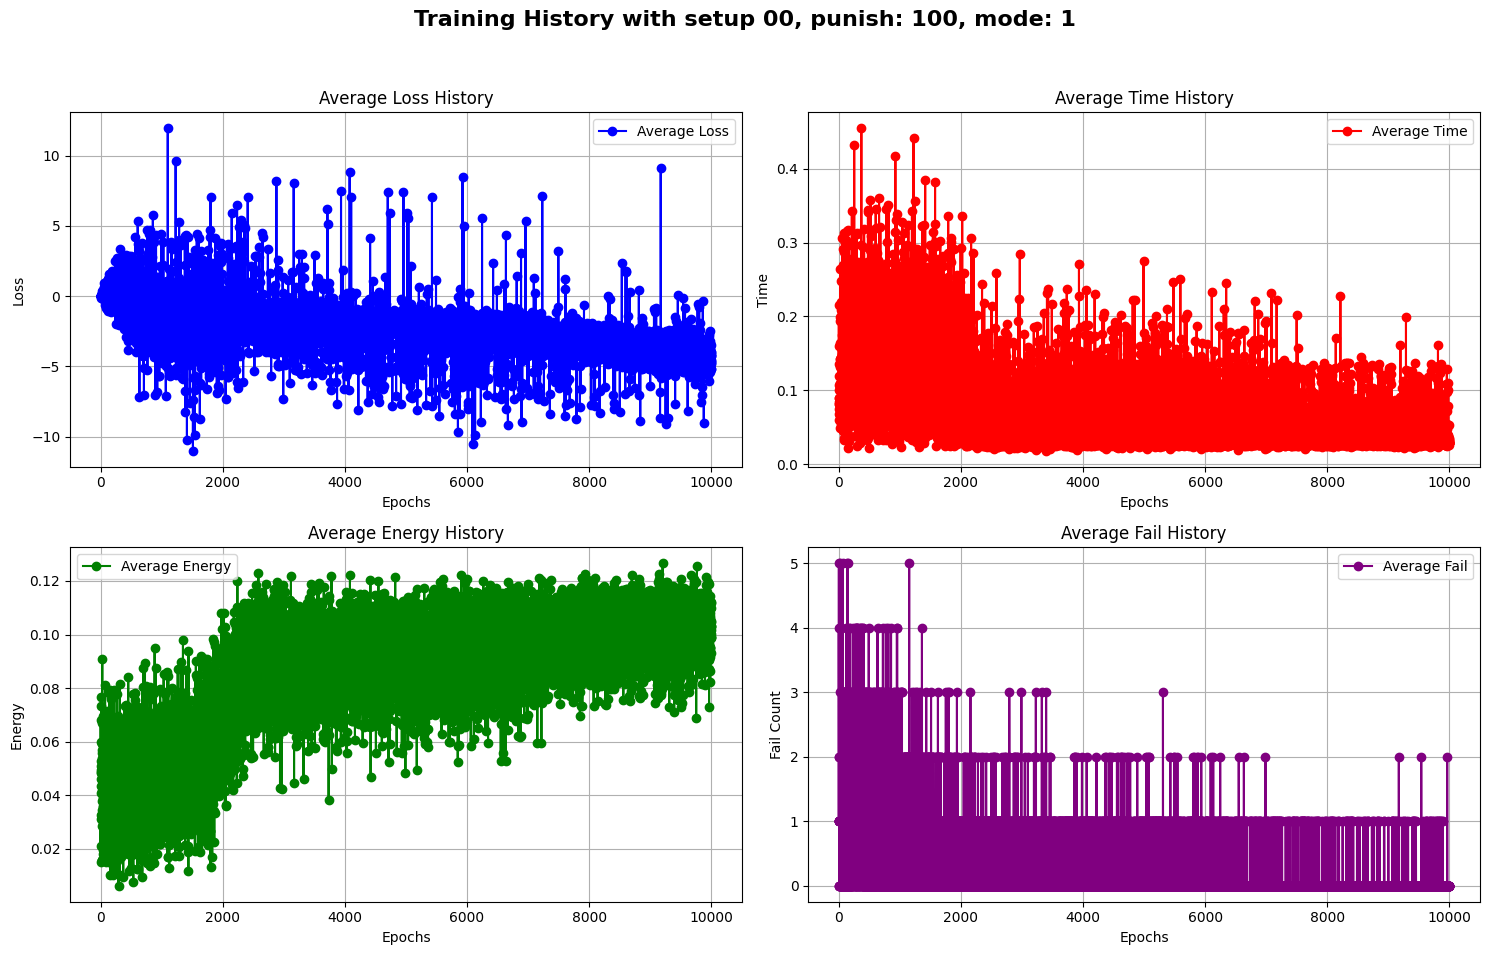

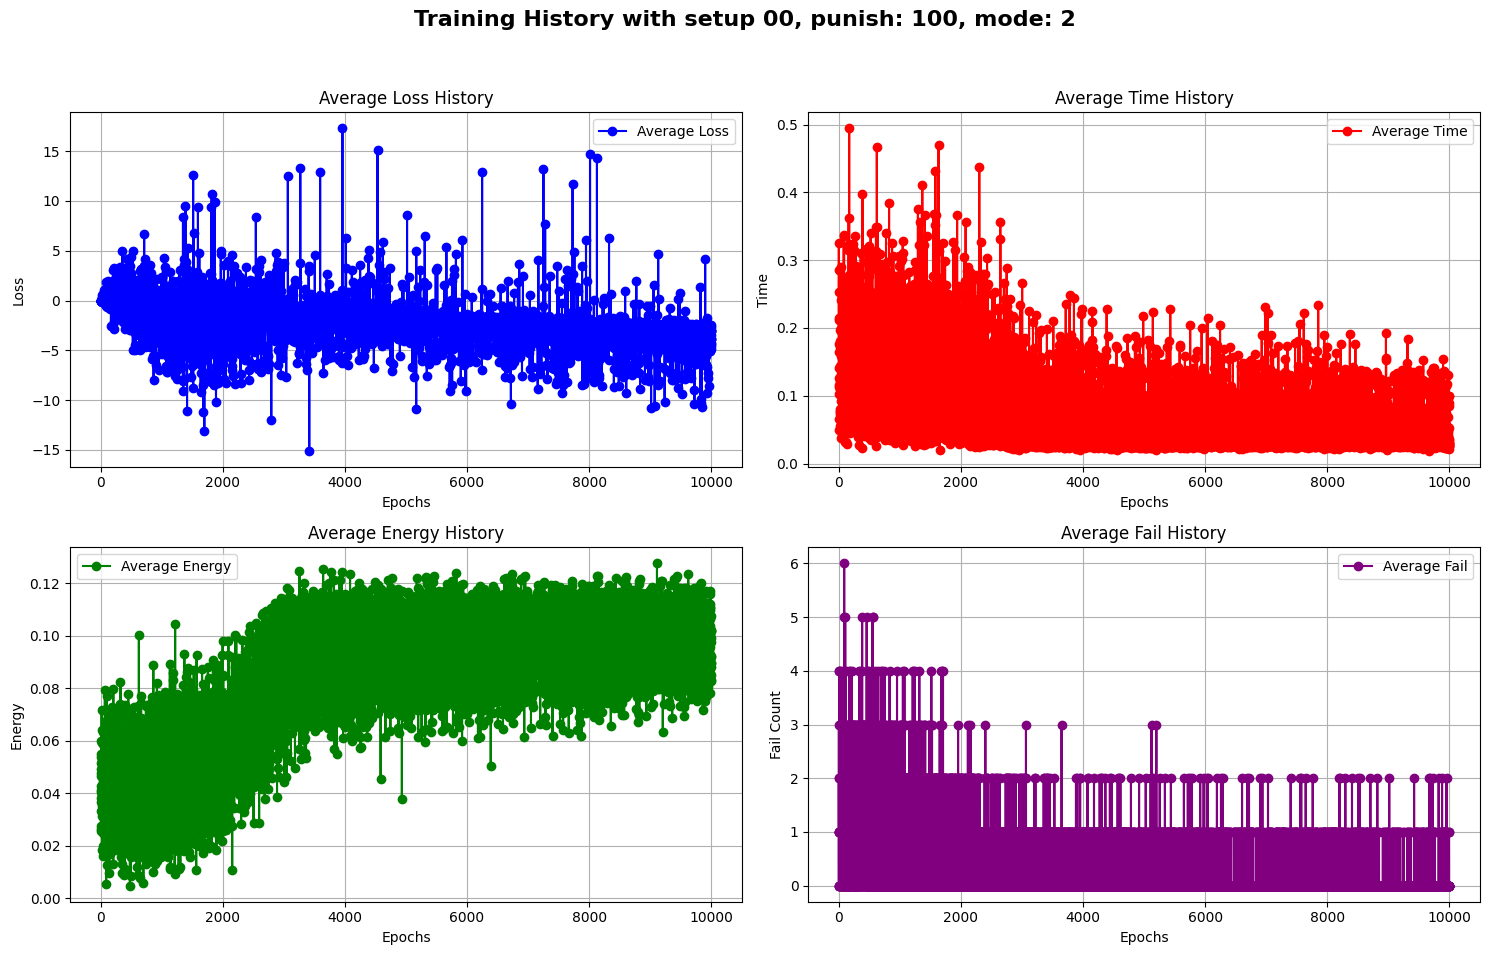

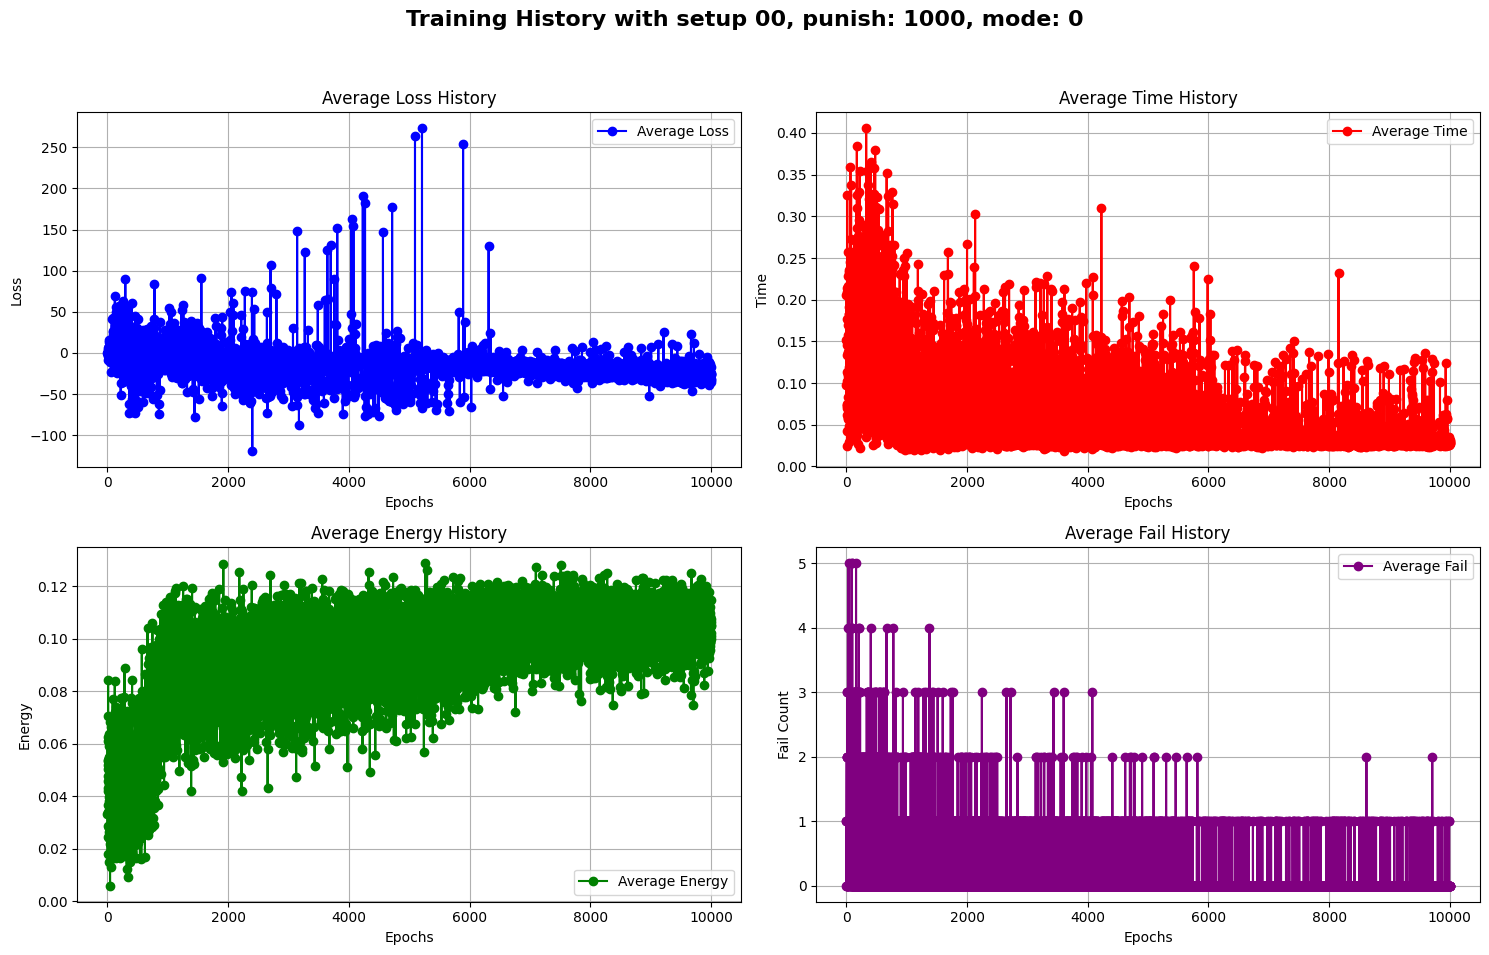

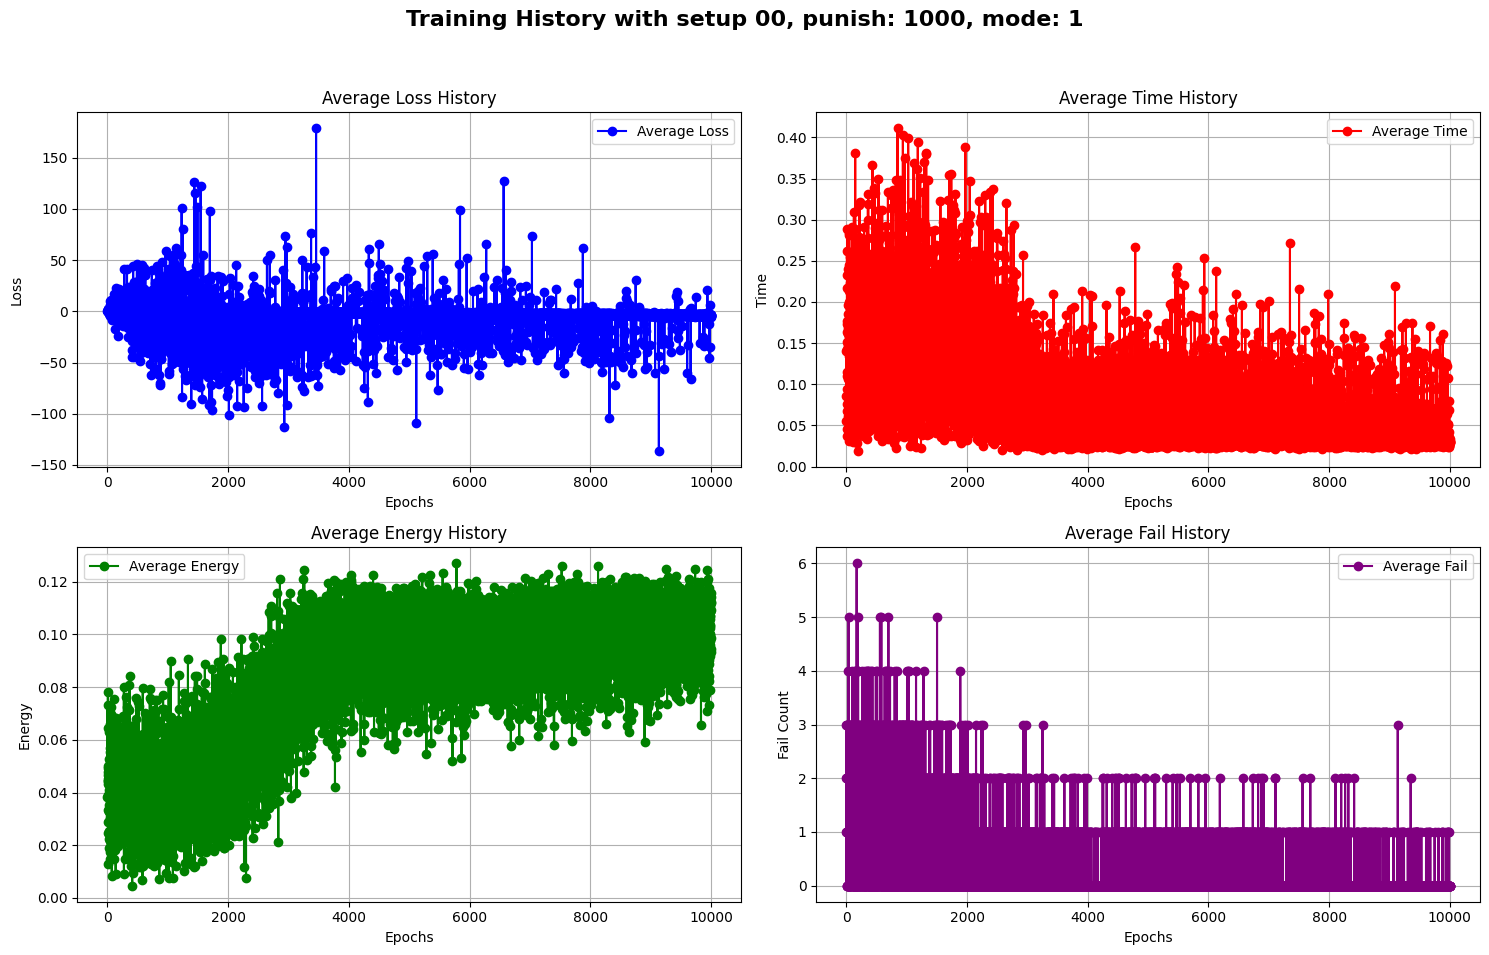

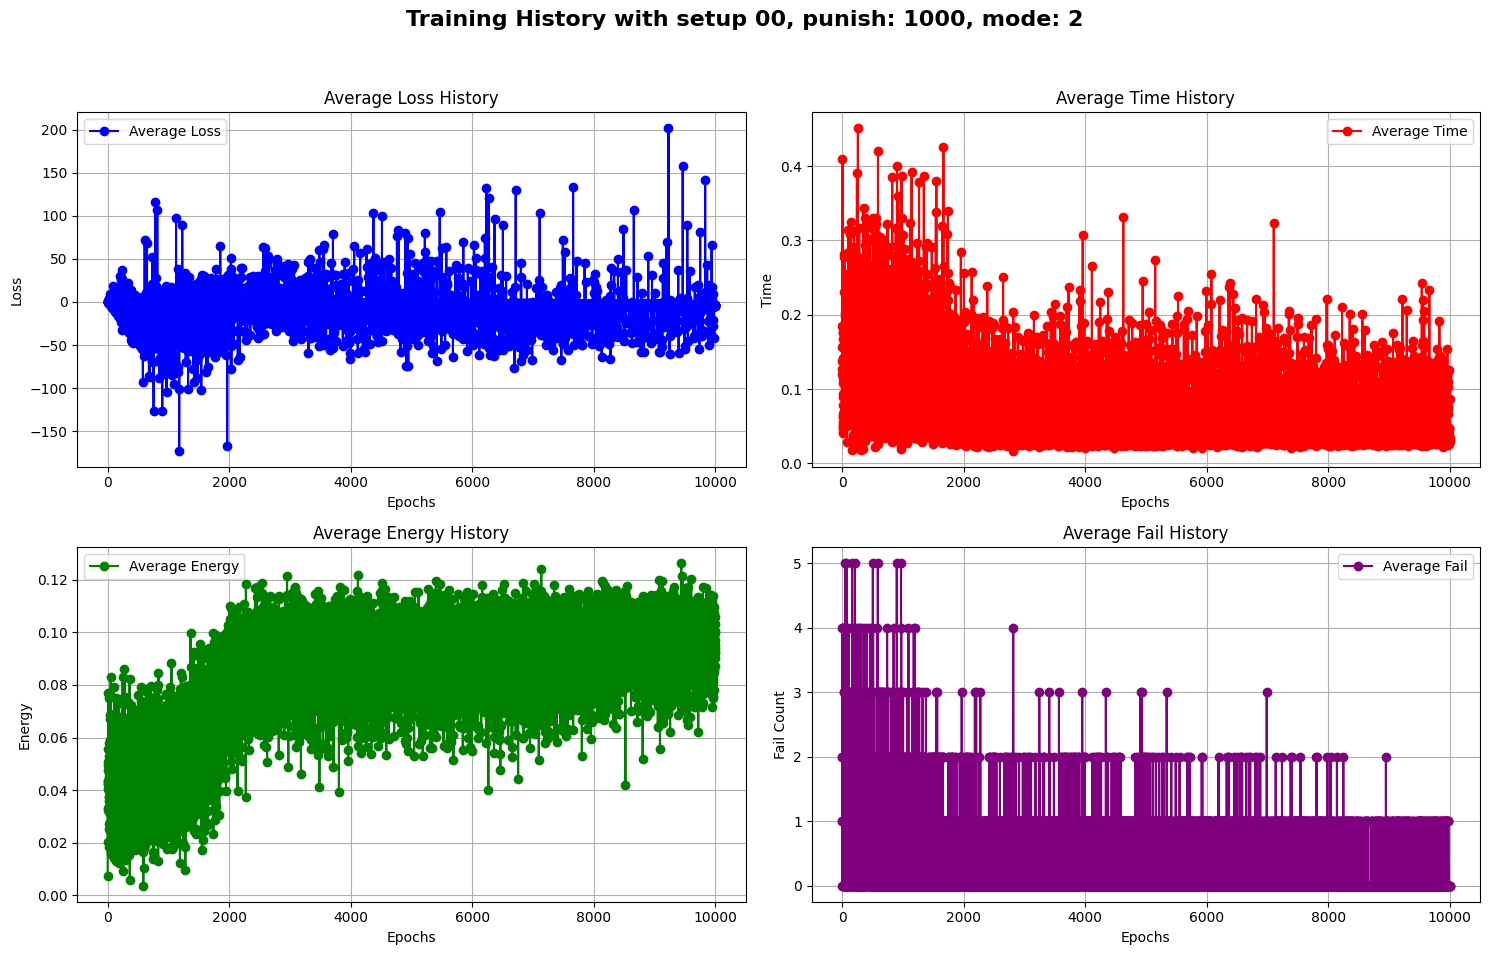

In [205]:

def train_test(n):
    rpSetup_list = {"00": [10, 100, 1000]}
    learningModes = [0, 1, 2]

    for i in range(n):
        for reward, punish_list in rpSetup_list.items():
            for punish in punish_list:
                    for mode in learningModes:
                        taskList, tasks_copy = read_tasks()
                        env = Environment()
                        env.learning_mode = mode
                        env.rSetup = reward
                        env.punish = punish
                        env.taskList = taskList
                        env.tasks_copy = tasks_copy
                        
                        tree = env.agent
                        env.train(10001, 10)

train_test(1)   
print("completed")


In [206]:


# # Load the data
# df = pd.read_csv(dataFile)

# # Sort the DataFrame by 'setup' column
# df = df.sort_values(by='Setup')

# # Save the sorted DataFrame back to the CSV
# df.to_csv(dataFile, index=False)

# print("CSV file sorted by 'setup'.")
